Veri seti boyutu: (2235, 13)

Veri tipleri:
 HastaNo             int64
Yas                 int64
Cinsiyet           object
KanGrubu           object
Uyruk              object
KronikHastalik     object
Bolum              object
Alerji             object
Tanilar            object
TedaviAdi          object
TedaviSuresi       object
UygulamaYerleri    object
UygulamaSuresi     object
dtype: object

Eksik değer sayıları:
 HastaNo              0
Yas                  0
Cinsiyet           169
KanGrubu           675
Uyruk                0
KronikHastalik     611
Bolum               11
Alerji             944
Tanilar             75
TedaviAdi            0
TedaviSuresi         0
UygulamaYerleri    221
UygulamaSuresi       0
dtype: int64

Hedef değişken (TedaviSuresi) özet istatistikleri:
 count         2235
unique          23
top       15 Seans
freq          1670
Name: TedaviSuresi, dtype: object


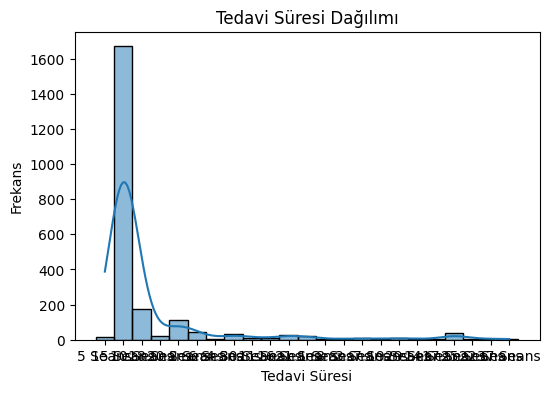

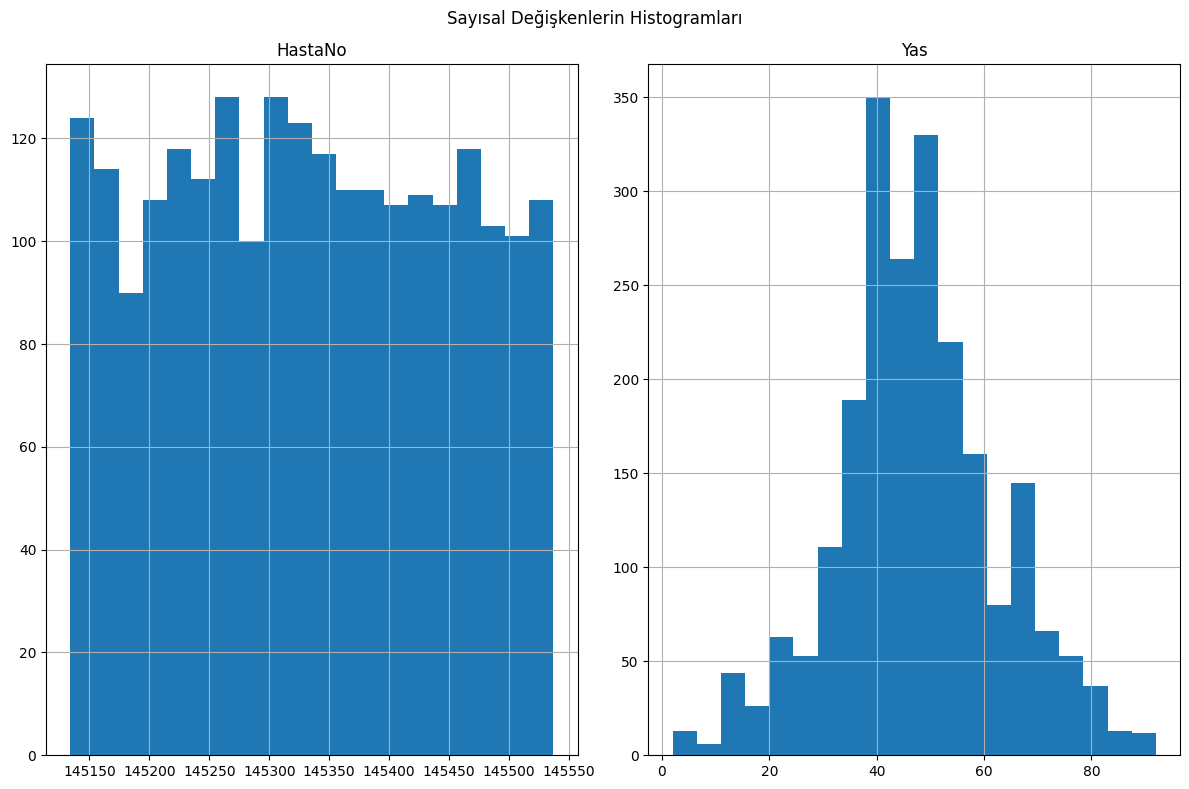

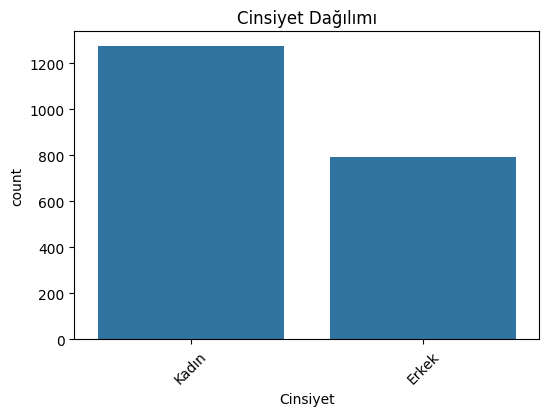

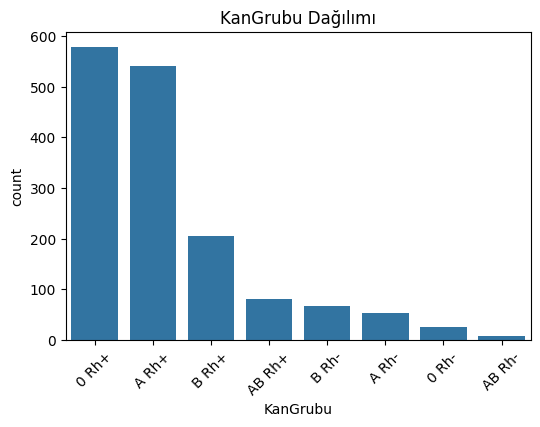

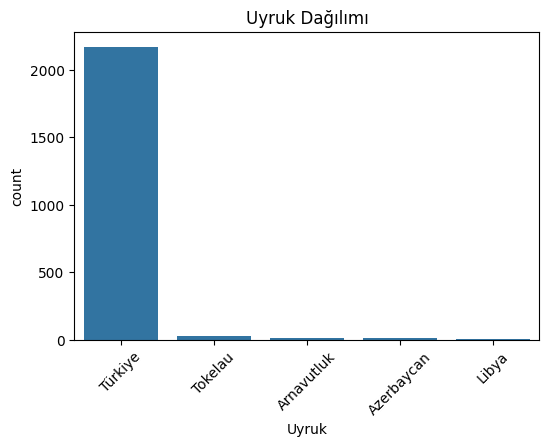

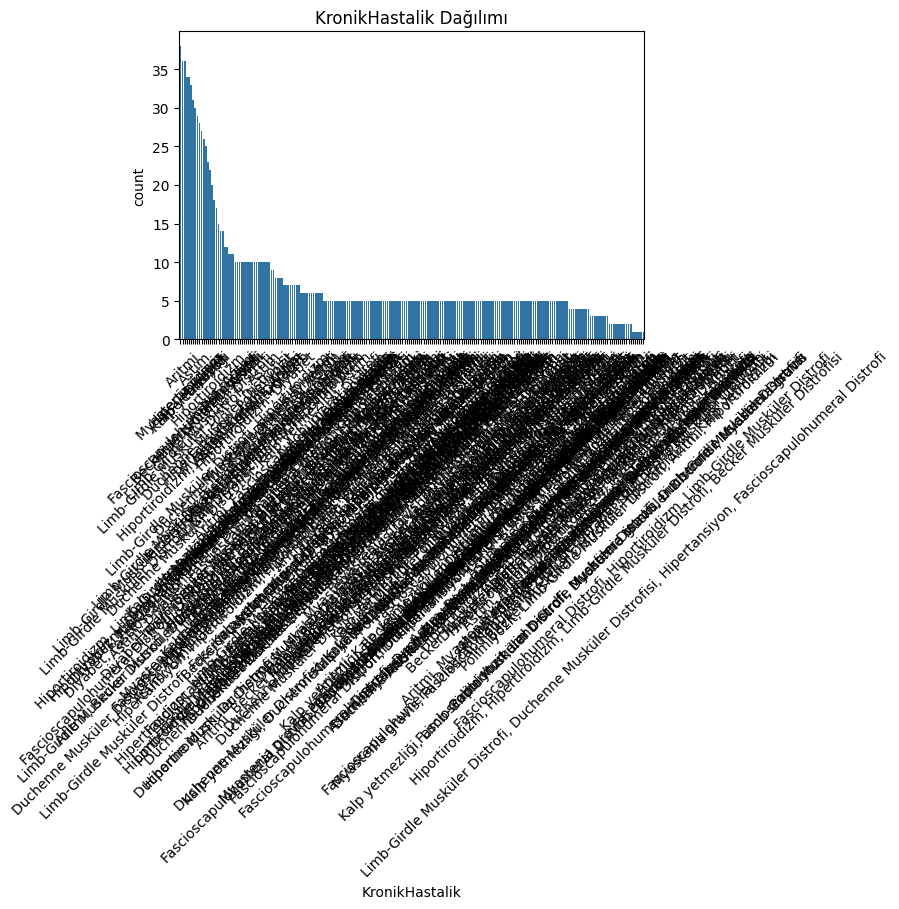

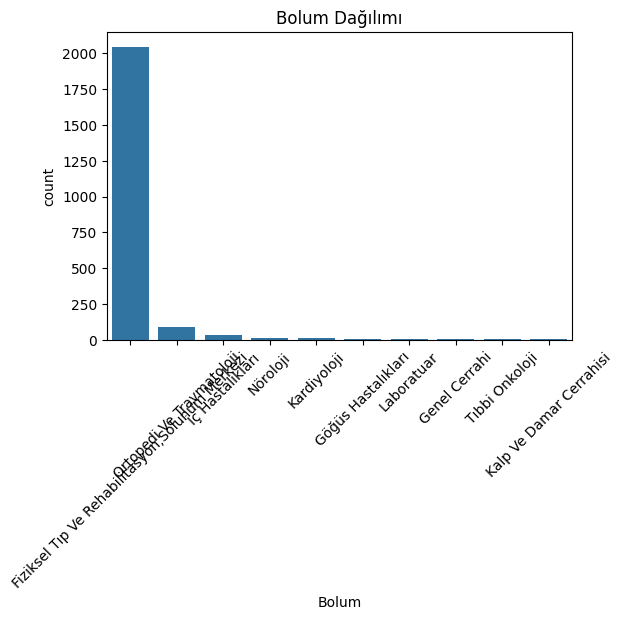

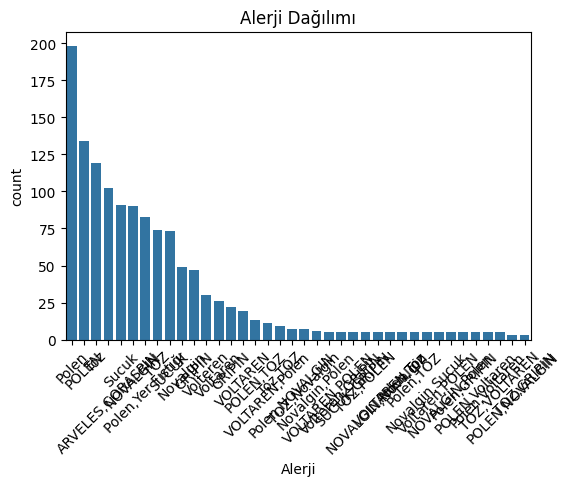

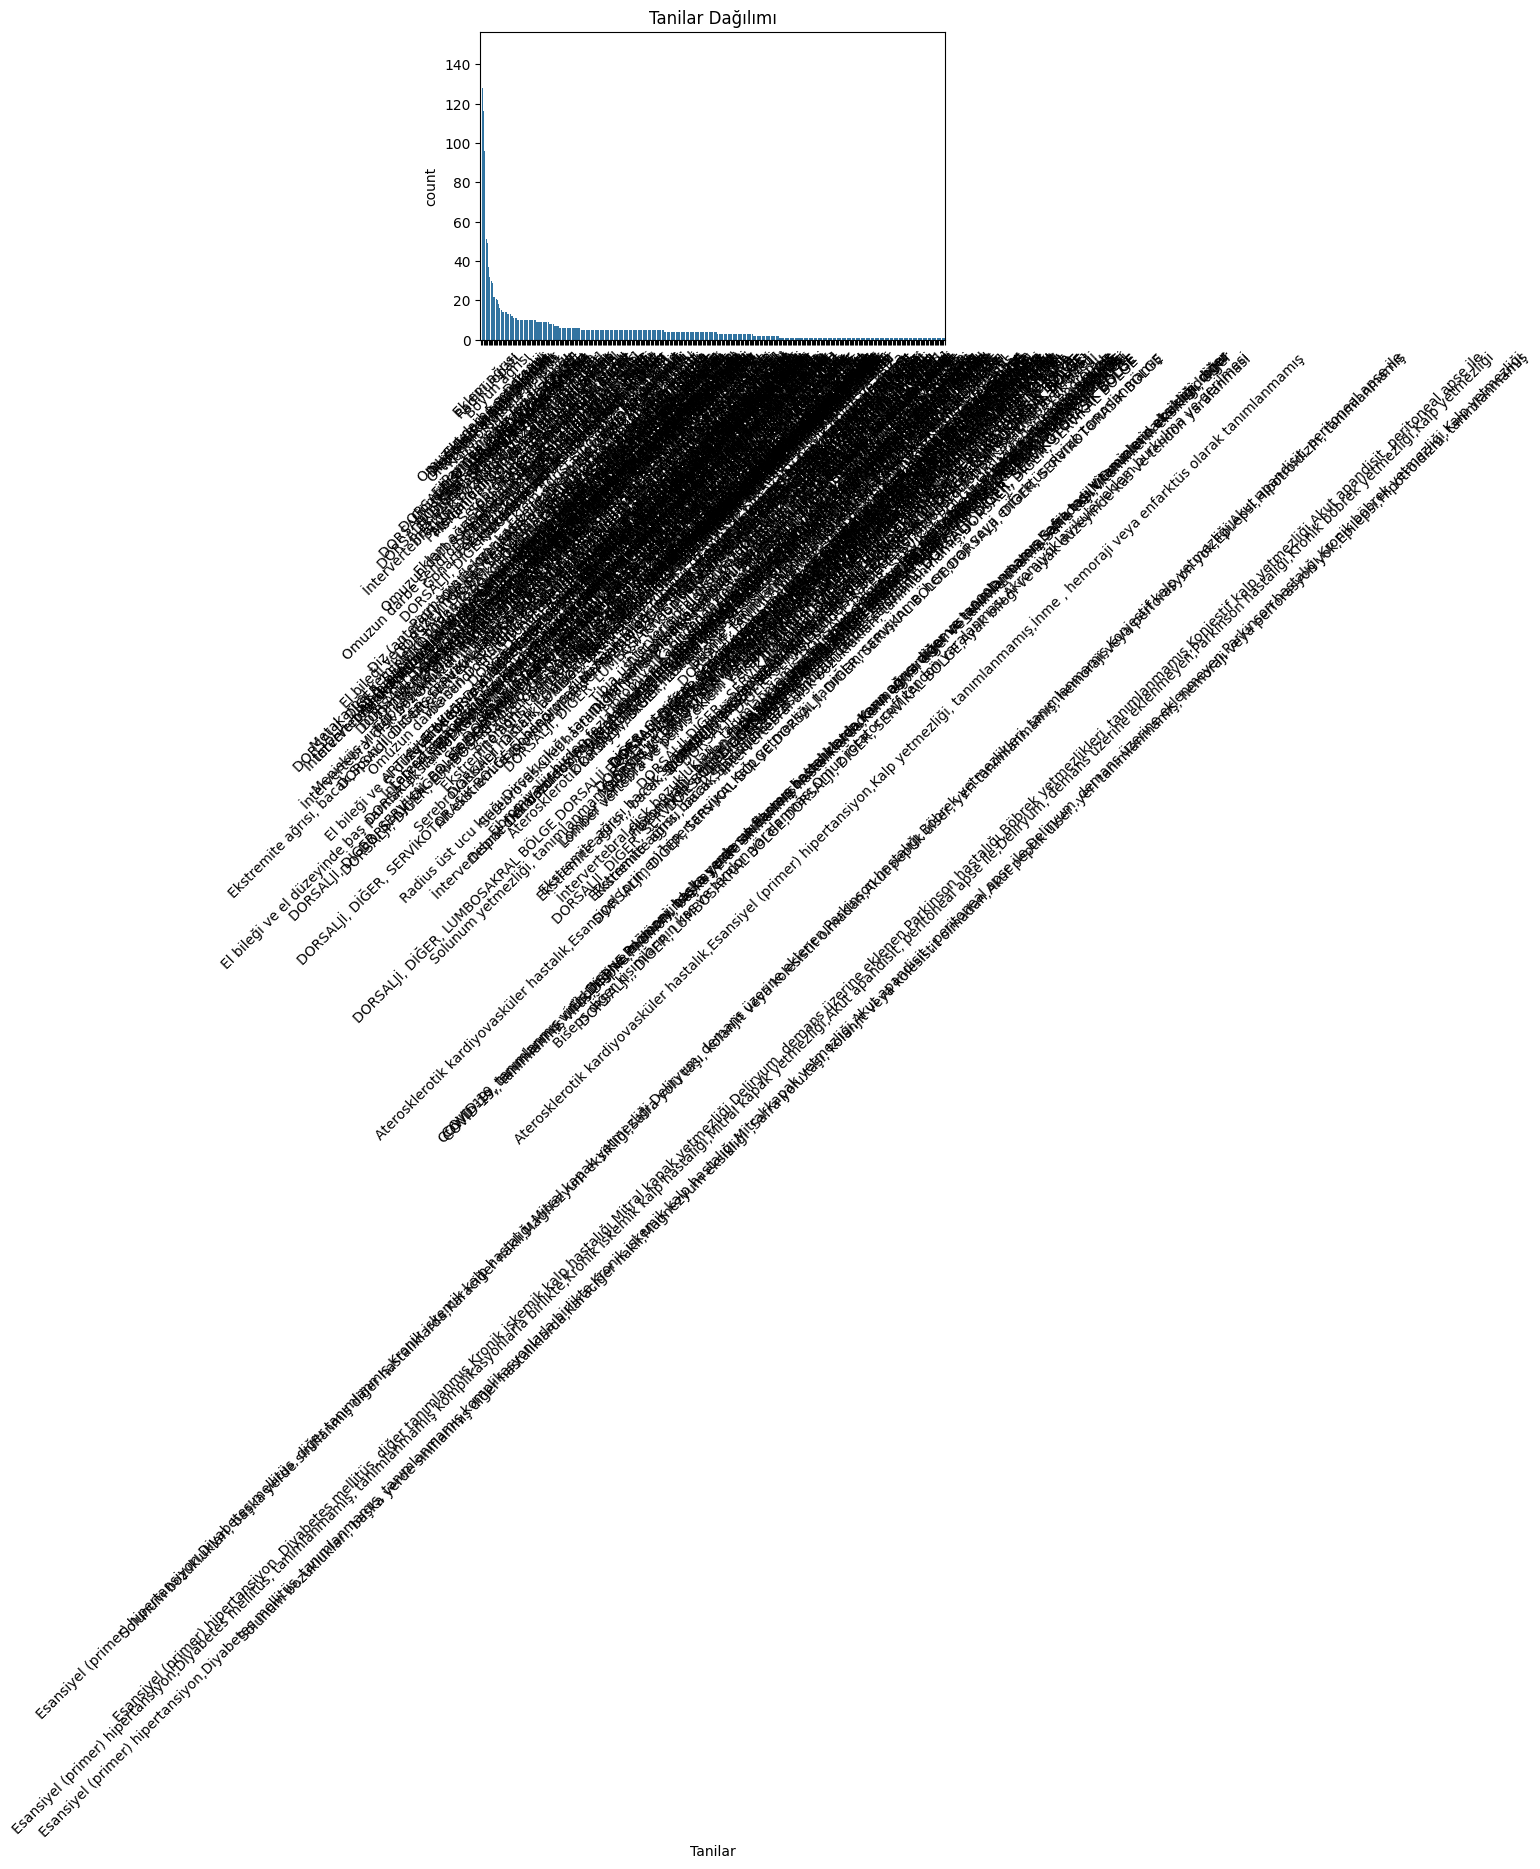

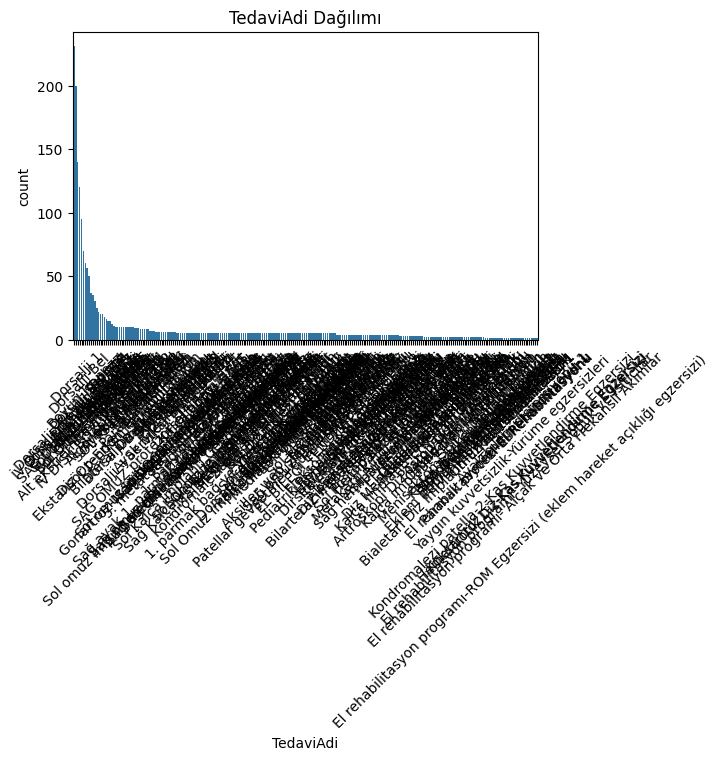

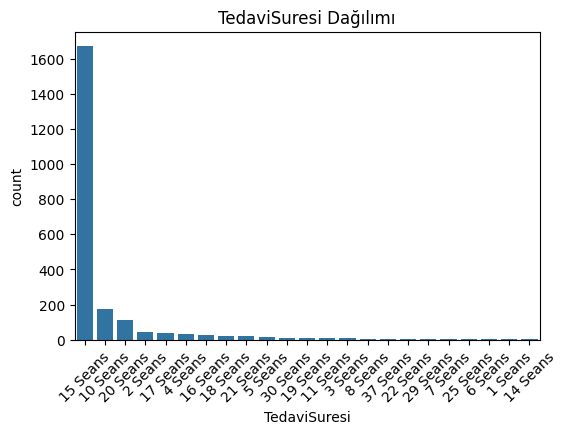

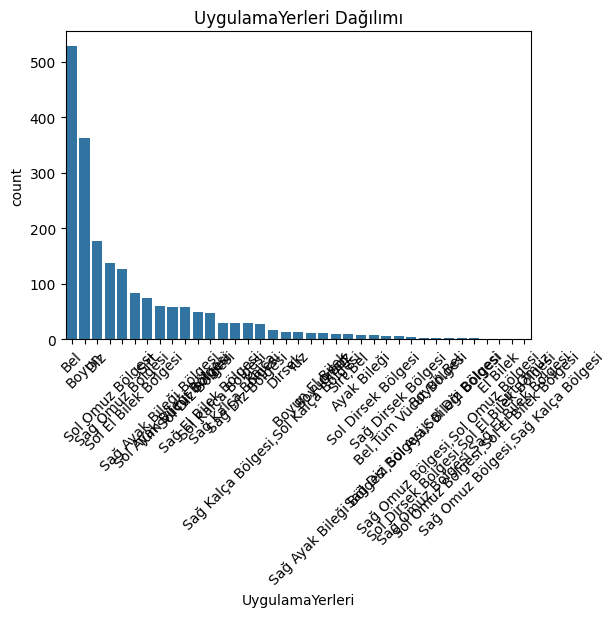

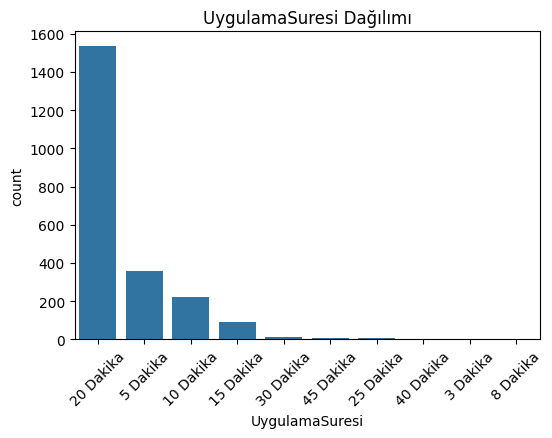

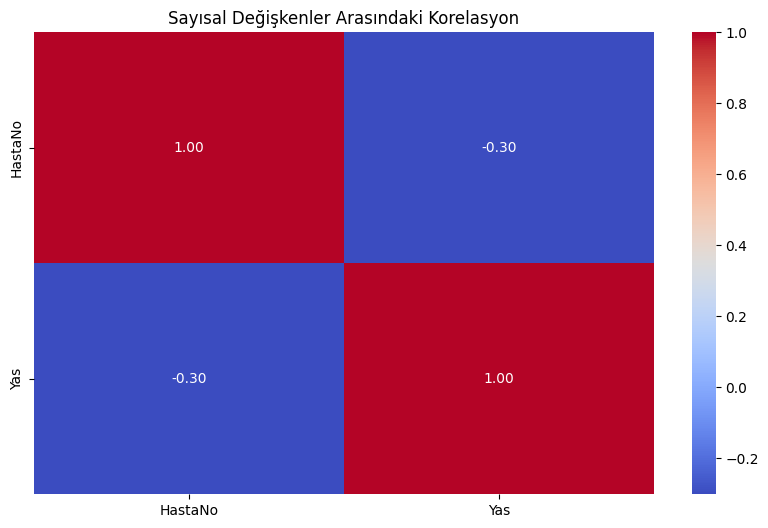

Düşük kardinaliteli kategorik kolonlar: ['Cinsiyet', 'KanGrubu', 'Uyruk', 'Bolum', 'UygulamaSuresi']
Yüksek kardinaliteli kolonlar: ['Tanilar', 'TedaviAdi', 'UygulamaYerleri']
İşlenmiş veri boyutu: (2235, 84)
    HastaNo       Yas  KronikHastalik_aritmi  KronikHastalik_astım  \
0 -1.728474  0.833459              -0.346034             -0.324563   
1 -1.719792 -1.271080              -0.346034             -0.324563   
2 -1.719792 -1.271080              -0.346034             -0.324563   
3 -1.719792 -1.271080              -0.346034             -0.324563   
4 -1.719792 -1.271080              -0.346034             -0.324563   

   KronikHastalik_becker_musküler_distrofisi  KronikHastalik_diyabet  \
0                                  -0.292367               -0.310907   
1                                   3.420360               -0.310907   
2                                   3.420360               -0.310907   
3                                   3.420360               -0.310907   
4         

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------
# 1. Veri Yükleme
# -------------------------------
df = pd.read_excel("Talent_Academy_Case_DT_2025.xlsx")

# -------------------------------
# 2. Hedef değişkeni ayırma
# -------------------------------
y = df["TedaviSuresi"]
X = df.drop(columns=["TedaviSuresi"])

# -------------------------------
# 3. EDA (Exploratory Data Analysis)
# -------------------------------
print("Veri seti boyutu:", df.shape)
print("\nVeri tipleri:\n", df.dtypes)
print("\nEksik değer sayıları:\n", df.isnull().sum())
print("\nHedef değişken (TedaviSuresi) özet istatistikleri:\n", y.describe())

# Hedef değişken dağılımı
plt.figure(figsize=(6,4))
sns.histplot(y, bins=20, kde=True)
plt.title("Tedavi Süresi Dağılımı")
plt.xlabel("Tedavi Süresi")
plt.ylabel("Frekans")
plt.show()

# Sayısal değişkenler için histogram
num_cols_full = df.select_dtypes(include=['int64','float64']).columns.tolist()
df[num_cols_full].hist(figsize=(12, 8), bins=20)
plt.suptitle("Sayısal Değişkenlerin Histogramları")
plt.tight_layout()
plt.show()

# Kategorik değişken dağılımları
cat_cols_full = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols_full:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"{col} Dağılımı")
    plt.xticks(rotation=45)
    plt.show()

# Korelasyon matrisi
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols_full].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Sayısal Değişkenler Arasındaki Korelasyon")
plt.show()

# -------------------------------
# 4. Özel fonksiyon: çoklu değer kolonları genişletme
# -------------------------------
def multi_label_binarize(df, column):
    """Virgülle ayrılmış değerleri ayrı sütunlara ayırır (one-hot), kolon isimlerini normalize eder."""
    df[column] = df[column].fillna("")
    expanded = df[column].str.get_dummies(sep=",").astype(int)

    # Kolon isimlerini normalize et → küçük harf, trim, boşlukları alt çizgi
    normalized_cols = [c.strip().lower().replace(" ", "_") for c in expanded.columns]

    # Çakışma varsa benzersiz yap
    seen = {}
    unique_cols = []
    for col in normalized_cols:
        if col in seen:
            seen[col] += 1
            unique_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            unique_cols.append(col)

    expanded.columns = [f"{column}_{c}" for c in unique_cols]
    return expanded

# KronikHastalik ve Alerji kolonlarını genişlet
kronik_dummies = multi_label_binarize(X, "KronikHastalik")
alerji_dummies = multi_label_binarize(X, "Alerji")

# Orijinal sütunları düşür
X = X.drop(columns=["KronikHastalik", "Alerji"])

# Yeni dummy sütunları ekle
X = pd.concat([X, kronik_dummies, alerji_dummies], axis=1)

# -------------------------------
# 5. Kardinalite kontrolü
# -------------------------------
def check_cardinality(df, cat_cols, threshold=20):
    """Kardinaliteyi ölçer ve yüksek kardinaliteli kolonları listeler."""
    high_card = []
    low_card = []
    for col in cat_cols:
        n_unique = df[col].nunique()
        if n_unique > threshold:
            high_card.append(col)
        else:
            low_card.append(col)
    return low_card, high_card

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

low_card, high_card = check_cardinality(X, cat_cols, threshold=20)

print("Düşük kardinaliteli kategorik kolonlar:", low_card)
print("Yüksek kardinaliteli kolonlar:", high_card)

# -------------------------------
# 6. Yüksek kardinaliteli kolonlar için frequency encoding
# -------------------------------
for col in high_card:
    freq_map = X[col].value_counts().to_dict()
    X[col] = X[col].map(freq_map)

# -------------------------------
# 7. Preprocessor
# -------------------------------
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
onehot = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", num_imputer),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline(steps=[
            ("imputer", cat_imputer),
            ("onehot", onehot)
        ]), low_card)
    ],
    remainder="passthrough"  # yüksek kardinalite + dummy sütunlar direkt geçiyor
)

# Fit & transform
processed = preprocessor.fit_transform(X)

# -------------------------------
# 8. Feature isimleri toparlama
# -------------------------------
# OneHot sonrası kategorik kolon isimlerini çıkar
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(low_card)

processed_cols = list(num_cols) + list(cat_features) \
                 + [col for col in X.columns if col not in num_cols + low_card]

processed_df = pd.DataFrame(processed.toarray() if hasattr(processed,"toarray") else processed,
                            columns=processed_cols)

# -------------------------------
# 9. Sonuç
# -------------------------------
print("İşlenmiş veri boyutu:", processed_df.shape)
print(processed_df.head())

# Kaydet
processed_df["TedaviSuresi"] = y.values
processed_df.to_csv("Processed_Data.csv", index=False)
print("Temizlenmiş veri 'Processed_Data.csv' olarak kaydedildi.")
